In [45]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from scipy.stats import gamma
import numpy as np
import c3aidatalake

# Consolidating all Factors into Single CSV File

* Proportion of all High-Risk Diseases
* Proportion of Unemployment
* Medical Preparedness
* Proportion of Race
* Social Distance Grade Score by Month
    * Will need to offset for incubation period (let's try without it first)
* Cases by Rural

# Dictionary of DataFrames

In [46]:
df_dict = {}

## List of Official CFPB Listed Rural Counties

In [47]:
rural = pd.read_csv('final_rural_counties.csv').iloc[:,1:]
rural.head()

,fips_code,county,state,c3_data_id
0,51001.0,Accomack,Virginia,Accomack_Virginia_UnitedStates
1,19001.0,Adair,Iowa,Adair_Iowa_UnitedStates
2,21001.0,Adair,Kentucky,Adair_Kentucky_UnitedStates
3,29001.0,Adair,Missouri,Adair_Missouri_UnitedStates
4,40001.0,Adair,Oklahoma,Adair_Oklahoma_UnitedStates


----

# High Risk Disease

In [48]:
hrd = pd.read_csv('all_county_disease.csv')
hrd.head(), hrd.shape

(  COUNTY_NAME STATE_NAME  FIPS  county_pop2018_18 and older  \
 0     Autauga    Alabama  1001                        42438   
 1     Baldwin    Alabama  1003                       170912   
 2     Barbour    Alabama  1005                        19689   
 3        Bibb    Alabama  1007                        17813   
 4      Blount    Alabama  1009                        44448   
 
    anycondition_number  Obesity_number  Heart disease_number  COPD_number  \
 0                20181           15193                  3345         3644   
 1                68790           50761                 13414        14692   
 2                11325            8013                  2159         2373   
 3                 9190            6894                  1533         1789   
 4                20584           15112                  4101         4661   
 
    diabetes_number  CKD_number  proportionAnyCondition  proportionObese  \
 0             5462        1326                0.475541         0.35

In [49]:
## We will be using any condition because the conditions 
## are not mutually exclusive (ex. can be obeses and also have heart disease, so we want to avoid excess counts)

## Isolating only rural counties
hrd_rural = hrd.loc[hrd['FIPS'].isin(list(rural['fips_code']))]
rural_conditions_proportion = hrd_rural.loc[:, ['FIPS', 'proportionAnyCondition']]
rural_conditions_proportion = rural_conditions_proportion.rename(columns= {'FIPS':'fips_code', 'proportionAnyCondition':'highrisk_prop'})
rural_conditions_proportion

,fips_code,highrisk_prop
2,1005,0.575194
5,1011,0.606549
6,1013,0.581035
9,1019,0.559310
11,1023,0.571929
...,...,...
3137,56037,0.402884
3138,56039,0.242862
3139,56041,0.422068
3140,56043,0.375082


----

# Unemployment Rate

In [50]:
raw_c3_data = pd.read_csv('raw_counties_info.csv')
raw_c3_data

,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,populationOfAllChildren,latestLaborForce,latestEmployedPopulation,latestUnemployedPopulation,latestUnemploymentRate,laborForceOfAllChildren,locationType,populationCDS,id,name,typeIdent,location.value.id,location.timestamp,fips.id
0,6.0,25.0,25.0,24527.0,24527.0,10090.0,9633.0,457.0,4.529237,10090.0,county,24527.0,Abbeville_SouthCarolina_UnitedStates,Abbeville,EP_LOC,Abbeville_SouthCarolina_UnitedStates,2020-11-11T00:00:00Z,45001.0
1,7.0,171.0,186.0,62045.0,62045.0,24074.0,22369.0,1705.0,7.082329,24074.0,county,62045.0,Acadia_Louisiana_UnitedStates,Acadia,EP_LOC,Acadia_Louisiana_UnitedStates,2020-11-11T00:00:00Z,22001.0
2,10.0,46.0,52.0,32316.0,32316.0,16001.0,15096.0,905.0,5.655897,16001.0,county,32316.0,Accomack_Virginia_UnitedStates,Accomack,EP_LOC,Accomack_Virginia_UnitedStates,2020-11-11T00:00:00Z,51001.0
3,97.0,1195.0,1305.0,481587.0,481587.0,263531.0,248015.0,15516.0,5.887732,263531.0,county,481587.0,Ada_Idaho_UnitedStates,Ada,EP_LOC,Ada_Idaho_UnitedStates,2020-11-11T00:00:00Z,16001.0
4,4.0,25.0,25.0,7152.0,7152.0,3862.0,3747.0,115.0,2.977732,3862.0,county,7152.0,Adair_Iowa_UnitedStates,Adair,EP_LOC,Adair_Iowa_UnitedStates,2020-11-11T00:00:00Z,19001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,42.0,447.0,456.0,213787.0,213787.0,97557.0,80938.0,16619.0,17.035169,97557.0,county,213787.0,Yuma_Arizona_UnitedStates,Yuma,EP_LOC,Yuma_Arizona_UnitedStates,2020-11-11T00:00:00Z,4027.0
3148,6.0,30.0,30.0,10019.0,10019.0,5010.0,4868.0,142.0,2.834331,5010.0,county,10019.0,Yuma_Colorado_UnitedStates,Yuma,EP_LOC,Yuma_Colorado_UnitedStates,2020-11-11T00:00:00Z,8125.0
3149,NaN,NaN,NaN,14179.0,14179.0,4947.0,4268.0,679.0,13.725490,4947.0,county,14179.0,Zapata_Texas_UnitedStates,Zapata,EP_LOC,Zapata_Texas_UnitedStates,2020-11-11T00:00:00Z,48505.0
3150,NaN,NaN,NaN,11840.0,11840.0,3309.0,2748.0,561.0,16.953762,3309.0,county,11840.0,Zavala_Texas_UnitedStates,Zavala,EP_LOC,Zavala_Texas_UnitedStates,2020-11-11T00:00:00Z,48507.0


In [51]:
rural_c3 = rural.merge(raw_c3_data, left_on = 'fips_code', right_on = 'fips.id')
rural_unemp_df = rural_c3[['fips_code','latestUnemploymentRate', 'populationCDS']]
rural_unemp_df['unemployment_proportion'] = rural_unemp_df['latestUnemploymentRate']/100
unemp_df = rural_unemp_df.iloc[:, [0,2,3]]

<ipython-input-51-5b9e6cc517eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rural_unemp_df['unemployment_proportion'] = rural_unemp_df['latestUnemploymentRate']/100


In [52]:
rural_df = rural_conditions_proportion.merge(unemp_df, on = 'fips_code')
rural_df

,fips_code,highrisk_prop,populationCDS,unemployment_proportion
0,1005,0.575194,24686.0,0.086062
1,1011,0.606549,10101.0,0.064734
2,1013,0.581035,19448.0,0.091001
3,1019,0.559310,26196.0,0.040000
4,1023,0.571929,12589.0,0.070606
...,...,...,...,...
1614,56037,0.402884,42343.0,0.069848
1615,56039,0.242862,23464.0,0.041664
1616,56041,0.422068,20226.0,0.063600
1617,56043,0.375082,7805.0,0.047112


----

# Medical Preparedness

To measure medical preparedness,  We will take a look at ICU Beds, not licensed beds. Licensed beds are all the of the beds that a hospital is licensed to have. This number will include beds reserved for non-covid patients. But because we want to know how prepared a county is for COVID medical preparedness we need to know how many ICU beds they have in total. Not every county in the US has a hospital, checked and referenced a 2020 [Kaiser Health Network Report](https://khn.org/news/as-coronavirus-spreads-widely-millions-of-older-americans-live-in-counties-with-no-icu-beds/) which discussed a lack of ICU Beds.

In [53]:
icu_zeros = rural_c3.fillna(value = 0)
icu_zeros

,fips_code,county,state,c3_data_id,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,populationOfAllChildren,latestLaborForce,...,latestUnemploymentRate,laborForceOfAllChildren,locationType,populationCDS,id,name,typeIdent,location.value.id,location.timestamp,fips.id
0,51001.0,Accomack,Virginia,Accomack_Virginia_UnitedStates,10.0,46.0,52.0,32316.0,32316.0,16001.0,...,5.655897,16001.0,county,32316.0,Accomack_Virginia_UnitedStates,Accomack,EP_LOC,Accomack_Virginia_UnitedStates,2020-11-11T00:00:00Z,51001.0
1,19001.0,Adair,Iowa,Adair_Iowa_UnitedStates,4.0,25.0,25.0,7152.0,7152.0,3862.0,...,2.977732,3862.0,county,7152.0,Adair_Iowa_UnitedStates,Adair,EP_LOC,Adair_Iowa_UnitedStates,2020-11-11T00:00:00Z,19001.0
2,21001.0,Adair,Kentucky,Adair_Kentucky_UnitedStates,0.0,0.0,0.0,19202.0,19202.0,6523.0,...,5.503603,6523.0,county,19202.0,Adair_Kentucky_UnitedStates,Adair,EP_LOC,Adair_Kentucky_UnitedStates,2020-11-11T00:00:00Z,21001.0
3,29001.0,Adair,Missouri,Adair_Missouri_UnitedStates,10.0,51.0,93.0,25343.0,25343.0,10077.0,...,2.987000,10077.0,county,25343.0,Adair_Missouri_UnitedStates,Adair,EP_LOC,Adair_Missouri_UnitedStates,2020-11-11T00:00:00Z,29001.0
4,40001.0,Adair,Oklahoma,Adair_Oklahoma_UnitedStates,5.0,30.0,67.0,22194.0,22194.0,8290.0,...,4.933655,8290.0,county,22194.0,Adair_Oklahoma_UnitedStates,Adair,EP_LOC,Adair_Oklahoma_UnitedStates,2020-11-11T00:00:00Z,40001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,48503.0,Young,Texas,Young_Texas_UnitedStates,8.0,50.0,50.0,18010.0,18010.0,7867.0,...,5.745519,7867.0,county,18010.0,Young_Texas_UnitedStates,Young,EP_LOC,Young_Texas_UnitedStates,2020-11-11T00:00:00Z,48503.0
1615,2290.0,Yukon-Koyukuk,Alaska,Yukon-Koyukuk_Alaska_UnitedStates,0.0,0.0,0.0,5230.0,5230.0,2261.0,...,8.801415,2261.0,county,5230.0,Yukon-Koyukuk_Alaska_UnitedStates,Yukon-Koyukuk Census Area,EP_LOC,Yukon-Koyukuk_Alaska_UnitedStates,2020-11-11T00:00:00Z,2290.0
1616,8125.0,Yuma,Colorado,Yuma_Colorado_UnitedStates,6.0,30.0,30.0,10019.0,10019.0,5010.0,...,2.834331,5010.0,county,10019.0,Yuma_Colorado_UnitedStates,Yuma,EP_LOC,Yuma_Colorado_UnitedStates,2020-11-11T00:00:00Z,8125.0
1617,48507.0,Zavala,Texas,Zavala_Texas_UnitedStates,0.0,0.0,0.0,11840.0,11840.0,3309.0,...,16.953762,3309.0,county,11840.0,Zavala_Texas_UnitedStates,Zavala,EP_LOC,Zavala_Texas_UnitedStates,2020-11-11T00:00:00Z,48507.0


In [54]:
icu_zeros['icu_beds_per_capita'] = icu_zeros['hospitalIcuBeds']/icu_zeros['populationCDS']
icu_zeros

,fips_code,county,state,c3_data_id,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,populationOfAllChildren,latestLaborForce,...,laborForceOfAllChildren,locationType,populationCDS,id,name,typeIdent,location.value.id,location.timestamp,fips.id,icu_beds_per_capita
0,51001.0,Accomack,Virginia,Accomack_Virginia_UnitedStates,10.0,46.0,52.0,32316.0,32316.0,16001.0,...,16001.0,county,32316.0,Accomack_Virginia_UnitedStates,Accomack,EP_LOC,Accomack_Virginia_UnitedStates,2020-11-11T00:00:00Z,51001.0,0.000309
1,19001.0,Adair,Iowa,Adair_Iowa_UnitedStates,4.0,25.0,25.0,7152.0,7152.0,3862.0,...,3862.0,county,7152.0,Adair_Iowa_UnitedStates,Adair,EP_LOC,Adair_Iowa_UnitedStates,2020-11-11T00:00:00Z,19001.0,0.000559
2,21001.0,Adair,Kentucky,Adair_Kentucky_UnitedStates,0.0,0.0,0.0,19202.0,19202.0,6523.0,...,6523.0,county,19202.0,Adair_Kentucky_UnitedStates,Adair,EP_LOC,Adair_Kentucky_UnitedStates,2020-11-11T00:00:00Z,21001.0,0.000000
3,29001.0,Adair,Missouri,Adair_Missouri_UnitedStates,10.0,51.0,93.0,25343.0,25343.0,10077.0,...,10077.0,county,25343.0,Adair_Missouri_UnitedStates,Adair,EP_LOC,Adair_Missouri_UnitedStates,2020-11-11T00:00:00Z,29001.0,0.000395
4,40001.0,Adair,Oklahoma,Adair_Oklahoma_UnitedStates,5.0,30.0,67.0,22194.0,22194.0,8290.0,...,8290.0,county,22194.0,Adair_Oklahoma_UnitedStates,Adair,EP_LOC,Adair_Oklahoma_UnitedStates,2020-11-11T00:00:00Z,40001.0,0.000225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,48503.0,Young,Texas,Young_Texas_UnitedStates,8.0,50.0,50.0,18010.0,18010.0,7867.0,...,7867.0,county,18010.0,Young_Texas_UnitedStates,Young,EP_LOC,Young_Texas_UnitedStates,2020-11-11T00:00:00Z,48503.0,0.000444
1615,2290.0,Yukon-Koyukuk,Alaska,Yukon-Koyukuk_Alaska_UnitedStates,0.0,0.0,0.0,5230.0,5230.0,2261.0,...,2261.0,county,5230.0,Yukon-Koyukuk_Alaska_UnitedStates,Yukon-Koyukuk Census Area,EP_LOC,Yukon-Koyukuk_Alaska_UnitedStates,2020-11-11T00:00:00Z,2290.0,0.000000
1616,8125.0,Yuma,Colorado,Yuma_Colorado_UnitedStates,6.0,30.0,30.0,10019.0,10019.0,5010.0,...,5010.0,county,10019.0,Yuma_Colorado_UnitedStates,Yuma,EP_LOC,Yuma_Colorado_UnitedStates,2020-11-11T00:00:00Z,8125.0,0.000599
1617,48507.0,Zavala,Texas,Zavala_Texas_UnitedStates,0.0,0.0,0.0,11840.0,11840.0,3309.0,...,3309.0,county,11840.0,Zavala_Texas_UnitedStates,Zavala,EP_LOC,Zavala_Texas_UnitedStates,2020-11-11T00:00:00Z,48507.0,0.000000


In [55]:
min(icu_zeros['icu_beds_per_capita']), max(icu_zeros['icu_beds_per_capita'])

(0.0, 0.003714020427112349)

In [56]:
min(icu_zeros['hospitalIcuBeds']), max(icu_zeros['hospitalIcuBeds'])

(0.0, 85.0)

There is very clearly a shortage of beds available per person in the US. And Not very many ICU beds prepared in general.

In [57]:
rural_icus = icu_zeros[['fips_code','icu_beds_per_capita']]
rural_icus

,fips_code,icu_beds_per_capita
0,51001.0,0.000309
1,19001.0,0.000559
2,21001.0,0.000000
3,29001.0,0.000395
4,40001.0,0.000225
...,...,...
1614,48503.0,0.000444
1615,2290.0,0.000000
1616,8125.0,0.000599
1617,48507.0,0.000000


In [58]:
rural_df = rural_df.merge(rural_icus, on='fips_code')
rural_df

,fips_code,highrisk_prop,populationCDS,unemployment_proportion,icu_beds_per_capita
0,1005,0.575194,24686.0,0.086062,0.000203
1,1011,0.606549,10101.0,0.064734,0.000495
2,1013,0.581035,19448.0,0.091001,0.000360
3,1019,0.559310,26196.0,0.040000,0.000305
4,1023,0.571929,12589.0,0.070606,0.000318
...,...,...,...,...,...
1614,56037,0.402884,42343.0,0.069848,0.000307
1615,56039,0.242862,23464.0,0.041664,0.000256
1616,56041,0.422068,20226.0,0.063600,0.000297
1617,56043,0.375082,7805.0,0.047112,0.000384


----

# Proportion of Race

In [59]:
all_county_race = pd.read_csv('race.csv')
all_county_race.head()

,proportionAIAN,proportionAsian,proportionBlack,proportionNHPI,proportionTwoOrMore,proportionWhite,parent.id
0,0.003376,0.004189,0.276610,0.000203,0.013910,0.701712,Abbeville_SouthCarolina_UnitedStates
1,0.003874,0.003134,0.181824,0.000305,0.015768,0.795094,Acadia_Louisiana_UnitedStates
2,0.006937,0.007980,0.285995,0.001596,0.017433,0.680059,Accomack_Virginia_UnitedStates
3,0.008042,0.027221,0.013533,0.002278,0.029117,0.919808,Ada_Idaho_UnitedStates
4,0.002545,0.005089,0.004948,0.000424,0.009613,0.977382,Adair_Iowa_UnitedStates


In [60]:
## Isolating rural counties
rural_race = all_county_race.loc[all_county_race['parent.id'].isin(list(rural['c3_data_id']))]
rural_race

,proportionAIAN,proportionAsian,proportionBlack,proportionNHPI,proportionTwoOrMore,proportionWhite,parent.id
2,0.006937,0.007980,0.285995,0.001596,0.017433,0.680059,Accomack_Virginia_UnitedStates
4,0.002545,0.005089,0.004948,0.000424,0.009613,0.977382,Adair_Iowa_UnitedStates
5,0.002813,0.003854,0.029533,0.000417,0.014063,0.949320,Adair_Kentucky_UnitedStates
6,0.003415,0.025279,0.031991,0.000667,0.019509,0.919140,Adair_Missouri_UnitedStates
7,0.460448,0.007964,0.006120,0.000720,0.102817,0.421931,Adair_Oklahoma_UnitedStates
...,...,...,...,...,...,...,...
3134,0.012565,0.007784,0.015679,0.000667,0.014789,0.948516,Young_Texas_UnitedStates
3136,0.699011,0.004665,0.009890,0.001306,0.056727,0.228401,Yukon-Koyukuk_Alaska_UnitedStates
3138,0.009048,0.005127,0.006032,0.002111,0.011159,0.966523,Yuma_Colorado_UnitedStates
3140,0.011279,0.002506,0.012616,0.001587,0.007018,0.964993,Zavala_Texas_UnitedStates


In [61]:
for i in range(1619):
    if rural['c3_data_id'][i] not in list(rural_race['parent.id']):
        print(rural['c3_data_id'][i])

O'Brien_Iowa_UnitedStates
St.Clair_Missouri_UnitedStates


---

# Social Distancing Grade (Outside Source: Unacast)

In [62]:
unacast_all = pd.read_csv('./rural_resurgence/unacast/unacast.csv')
## confirming only all rural counties present; previously sorted so just making sure
if unacast_all.countyFips.nunique() == rural.fips_code.nunique():
    print('Yay! All Rural counties!')
    
unacast_all

Yay! All Rural counties!


,FIPS,stateFips,stateName,stateCode,countyFips,countyName,date,totalGrade
0,1,1.0,Alabama,AL,1025.0,Clarke County,2020-11-08,D+
1,1,1.0,Alabama,AL,1025.0,Clarke County,2020-11-07,D
2,1,1.0,Alabama,AL,1025.0,Clarke County,2020-11-06,D
3,1,1.0,Alabama,AL,1025.0,Clarke County,2020-11-05,D
4,1,1.0,Alabama,AL,1025.0,Clarke County,2020-11-04,D
...,...,...,...,...,...,...,...,...
422390,56,56.0,Wyoming,WY,56043.0,Washakie County,2020-02-28,C
422391,56,56.0,Wyoming,WY,56043.0,Washakie County,2020-02-27,C
422392,56,56.0,Wyoming,WY,56043.0,Washakie County,2020-02-26,C
422393,56,56.0,Wyoming,WY,56043.0,Washakie County,2020-02-25,C


### Mapping totalGrade Letter Score to a Numeric Value

Originally, the scale from Unacast was from 1-5 with lower scores corresponding to a better social distance grade and so we mapped a similar scale to the totalGrade column for comparison and average grading. We changed the scale from A = 1, B = 2, C = 3, D = 4, F =5 to map it to a more consistent scale to accommodate partial scores (+ and -). Modeled after GPA scaling.

In [63]:
SDG_dict = {"F":5, "D-":4.7,"D": 4.3, "D+":4, "C-":3.7, "C": 3.3, "C+":3, "B-":2.7, "B": 2.3 , "B+":2, "A-":1.7, "A":1, "A+": 1}

In [64]:
unacast_all['grade_num'] = unacast_all['totalGrade'].map(SDG_dict)
unacast_all

,FIPS,stateFips,stateName,stateCode,countyFips,countyName,date,totalGrade,grade_num
0,1,1.0,Alabama,AL,1025.0,Clarke County,2020-11-08,D+,4.0
1,1,1.0,Alabama,AL,1025.0,Clarke County,2020-11-07,D,4.3
2,1,1.0,Alabama,AL,1025.0,Clarke County,2020-11-06,D,4.3
3,1,1.0,Alabama,AL,1025.0,Clarke County,2020-11-05,D,4.3
4,1,1.0,Alabama,AL,1025.0,Clarke County,2020-11-04,D,4.3
...,...,...,...,...,...,...,...,...,...
422390,56,56.0,Wyoming,WY,56043.0,Washakie County,2020-02-28,C,3.3
422391,56,56.0,Wyoming,WY,56043.0,Washakie County,2020-02-27,C,3.3
422392,56,56.0,Wyoming,WY,56043.0,Washakie County,2020-02-26,C,3.3
422393,56,56.0,Wyoming,WY,56043.0,Washakie County,2020-02-25,C,3.3


### Monthly Social Distance Grade for Each Rural County

In [65]:
import datetime

In [66]:
# date is formatted as string so reformatted to datetime 
unacast_all['month'] = pd.to_datetime(unacast_all['date'], format='%Y-%m-%d').dt.month_name()

# groupby countyFips and date
unacast_month = unacast_all.groupby([unacast_all["countyFips"], unacast_all['month']])['grade_num'].mean()
sdg_month = pd.DataFrame(unacast_month)
sdg_month.index = sdg_month.index.set_names(['countyFips', 'month'])
sdg_month

grade_num
countyFips month               
1005.0     April       4.040000
           August      4.509677
           February    4.750000
           July        4.745455
           June        4.743333
...                         ...
56045.0    March       2.996774
           May         3.054839
           November    3.175000
           October     3.022581
           September   3.100000

[16190 rows x 1 columns]

#### What about the Null Values?

Filling them with the monthly averages from all the counties

In [67]:
average_sdg_per_month = unacast_all.groupby(unacast_all['month'])['grade_num'].mean()
average_sdg_per_month

month
April        3.237983
August       3.879737
February     3.958491
July         3.903897
June         3.881027
March        3.623934
May          3.709665
November     3.622435
October      3.727534
September    3.787422
Name: grade_num, dtype: float64

In [68]:
month_avg = dict(average_sdg_per_month)

### Backfilling Holes

In [69]:
sdg_month.reset_index(inplace = True)
sdg_month

,countyFips,month,grade_num
0,1005.0,April,4.040000
1,1005.0,August,4.509677
2,1005.0,February,4.750000
3,1005.0,July,4.745455
4,1005.0,June,4.743333
...,...,...,...
16185,56045.0,March,2.996774
16186,56045.0,May,3.054839
16187,56045.0,November,3.175000
16188,56045.0,October,3.022581


In [70]:
sdg_month['month_avg'] = sdg_month.month.map(month_avg)

In [71]:
sdg_month

,countyFips,month,grade_num,month_avg
0,1005.0,April,4.040000,3.237983
1,1005.0,August,4.509677,3.879737
2,1005.0,February,4.750000,3.958491
3,1005.0,July,4.745455,3.903897
4,1005.0,June,4.743333,3.881027
...,...,...,...,...
16185,56045.0,March,2.996774,3.623934
16186,56045.0,May,3.054839,3.709665
16187,56045.0,November,3.175000,3.622435
16188,56045.0,October,3.022581,3.727534


In [72]:
sdg_month['grade_num'] = sdg_month['grade_num'].fillna(sdg_month['month_avg'])
sdg_month

,countyFips,month,grade_num,month_avg
0,1005.0,April,4.040000,3.237983
1,1005.0,August,4.509677,3.879737
2,1005.0,February,4.750000,3.958491
3,1005.0,July,4.745455,3.903897
4,1005.0,June,4.743333,3.881027
...,...,...,...,...
16185,56045.0,March,2.996774,3.623934
16186,56045.0,May,3.054839,3.709665
16187,56045.0,November,3.175000,3.622435
16188,56045.0,October,3.022581,3.727534


In [73]:
sdg_month.isna().sum()

countyFips    0
month         0
grade_num     0
month_avg     0
dtype: int64

In [74]:
sdg_month

,countyFips,month,grade_num,month_avg
0,1005.0,April,4.040000,3.237983
1,1005.0,August,4.509677,3.879737
2,1005.0,February,4.750000,3.958491
3,1005.0,July,4.745455,3.903897
4,1005.0,June,4.743333,3.881027
...,...,...,...,...
16185,56045.0,March,2.996774,3.623934
16186,56045.0,May,3.054839,3.709665
16187,56045.0,November,3.175000,3.622435
16188,56045.0,October,3.022581,3.727534


In [75]:
sdg_pivot = sdg_month.pivot(index = "countyFips", columns = "month", values = "grade_num")
sdg_pivot

month,April,August,February,July,June,March,May,November,October,September
countyFips,,,,,,,,,,
1005.0,4.040000,4.509677,4.750000,4.745455,4.743333,4.441935,4.748387,4.2625,4.338710,4.430000
1011.0,2.960000,3.280645,3.366667,3.300000,3.313333,3.164516,3.261290,3.3000,3.274194,3.280000
1013.0,3.596667,4.470968,4.783333,4.748485,4.713333,4.261290,4.370968,4.3000,4.348387,4.386667
1019.0,4.166667,5.000000,5.000000,5.000000,5.000000,4.600000,4.880645,4.7250,4.806452,4.900000
1023.0,3.676667,4.167742,4.300000,4.133333,4.110000,4.074194,3.980645,4.0375,4.074194,4.120000
...,...,...,...,...,...,...,...,...,...,...
56037.0,3.936667,4.000000,4.000000,4.000000,4.000000,3.967742,4.000000,4.0000,3.977419,3.976667
56039.0,1.573333,3.429032,3.300000,3.700000,3.460000,2.703226,2.529032,2.9000,3.280645,3.300000
56041.0,2.973333,4.029032,4.000000,4.054545,4.000000,3.525806,3.861290,3.9625,3.990323,3.990000


# Final CSV of Data

Have: 
* rural counties key (rural df)
* Proportion of High Risk (rural_conditions_proportion df)
* SDG (sdg_month df)

In [76]:
rural_df

,fips_code,highrisk_prop,populationCDS,unemployment_proportion,icu_beds_per_capita
0,1005,0.575194,24686.0,0.086062,0.000203
1,1011,0.606549,10101.0,0.064734,0.000495
2,1013,0.581035,19448.0,0.091001,0.000360
3,1019,0.559310,26196.0,0.040000,0.000305
4,1023,0.571929,12589.0,0.070606,0.000318
...,...,...,...,...,...
1614,56037,0.402884,42343.0,0.069848,0.000307
1615,56039,0.242862,23464.0,0.041664,0.000256
1616,56041,0.422068,20226.0,0.063600,0.000297
1617,56043,0.375082,7805.0,0.047112,0.000384


In [77]:
sdg = rural_df.merge(sdg_pivot, left_on='fips_code', right_on = "countyFips")
sdg

,fips_code,highrisk_prop,populationCDS,unemployment_proportion,icu_beds_per_capita,April,August,February,July,June,March,May,November,October,September
0,1005,0.575194,24686.0,0.086062,0.000203,4.040000,4.509677,4.750000,4.745455,4.743333,4.441935,4.748387,4.2625,4.338710,4.430000
1,1011,0.606549,10101.0,0.064734,0.000495,2.960000,3.280645,3.366667,3.300000,3.313333,3.164516,3.261290,3.3000,3.274194,3.280000
2,1013,0.581035,19448.0,0.091001,0.000360,3.596667,4.470968,4.783333,4.748485,4.713333,4.261290,4.370968,4.3000,4.348387,4.386667
3,1019,0.559310,26196.0,0.040000,0.000305,4.166667,5.000000,5.000000,5.000000,5.000000,4.600000,4.880645,4.7250,4.806452,4.900000
4,1023,0.571929,12589.0,0.070606,0.000318,3.676667,4.167742,4.300000,4.133333,4.110000,4.074194,3.980645,4.0375,4.074194,4.120000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,56037,0.402884,42343.0,0.069848,0.000307,3.936667,4.000000,4.000000,4.000000,4.000000,3.967742,4.000000,4.0000,3.977419,3.976667
1615,56039,0.242862,23464.0,0.041664,0.000256,1.573333,3.429032,3.300000,3.700000,3.460000,2.703226,2.529032,2.9000,3.280645,3.300000
1616,56041,0.422068,20226.0,0.063600,0.000297,2.973333,4.029032,4.000000,4.054545,4.000000,3.525806,3.861290,3.9625,3.990323,3.990000
1617,56043,0.375082,7805.0,0.047112,0.000384,2.320000,3.158065,3.300000,3.136364,3.073333,2.758065,3.016129,2.3250,2.783871,2.966667


----

# Monthly Cases - Cumulative and New Cases

In [78]:
new_cases = pd.read_csv('monthly_rural_new_cases.csv')

In [79]:
cases = rural_df.merge(new_cases, on='fips_code')
cases

,fips_code,highrisk_prop,populationCDS,unemployment_proportion,icu_beds_per_capita,February,March,April,May,June,July,August,September,October,November
0,1005,0.575194,24686.0,0.086062,0.000203,0.0,0.0,39.0,128.0,155.0,228.0,78.0,268.0,164.0,63.0
1,1011,0.606549,10101.0,0.064734,0.000495,0.0,3.0,10.0,196.0,151.0,70.0,107.0,73.0,43.0,22.0
2,1013,0.581035,19448.0,0.091001,0.000360,0.0,1.0,52.0,358.0,193.0,135.0,98.0,80.0,105.0,65.0
3,1019,0.559310,26196.0,0.040000,0.000305,0.0,2.0,13.0,22.0,34.0,148.0,127.0,274.0,163.0,115.0
4,1023,0.571929,12589.0,0.070606,0.000318,0.0,3.0,40.0,110.0,38.0,80.0,45.0,36.0,43.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,56037,0.402884,42343.0,0.069848,0.000307,0.0,2.0,16.0,12.0,60.0,150.0,62.0,37.0,149.0,536.0
1615,56039,0.242862,23464.0,0.041664,0.000256,0.0,20.0,76.0,4.0,29.0,206.0,95.0,147.0,225.0,354.0
1616,56041,0.422068,20226.0,0.063600,0.000297,0.0,0.0,8.0,4.0,164.0,78.0,44.0,59.0,127.0,235.0
1617,56043,0.375082,7805.0,0.047112,0.000384,0.0,1.0,7.0,28.0,3.0,9.0,60.0,8.0,26.0,66.0


## New Case Rate = New Cases / population

## New Case Rate = New Cases/ Last Month's n cases

- Because we are look at rate of change

In [80]:
case_prop = cases.copy()
month_col = cases.columns[5:]
month_col[0]
for i in range(len(month_col)):
    case_prop[month_col[i]] = cases[month_col[i]]/cases['populationCDS']
case_prop = case_prop.drop(columns = list(rural_df)[1:])
case_prop

,fips_code,February,March,April,May,June,July,August,September,October,November
0,1005,0.0,0.000000,0.001580,0.005185,0.006279,0.009236,0.003160,0.010856,0.006643,0.002552
1,1011,0.0,0.000297,0.000990,0.019404,0.014949,0.006930,0.010593,0.007227,0.004257,0.002178
2,1013,0.0,0.000051,0.002674,0.018408,0.009924,0.006942,0.005039,0.004114,0.005399,0.003342
3,1019,0.0,0.000076,0.000496,0.000840,0.001298,0.005650,0.004848,0.010460,0.006222,0.004390
4,1023,0.0,0.000238,0.003177,0.008738,0.003019,0.006355,0.003575,0.002860,0.003416,0.001192
...,...,...,...,...,...,...,...,...,...,...,...
1614,56037,0.0,0.000047,0.000378,0.000283,0.001417,0.003542,0.001464,0.000874,0.003519,0.012659
1615,56039,0.0,0.000852,0.003239,0.000170,0.001236,0.008779,0.004049,0.006265,0.009589,0.015087
1616,56041,0.0,0.000000,0.000396,0.000198,0.008108,0.003856,0.002175,0.002917,0.006279,0.011619
1617,56043,0.0,0.000128,0.000897,0.003587,0.000384,0.001153,0.007687,0.001025,0.003331,0.008456


In [81]:
sdg

,fips_code,highrisk_prop,populationCDS,unemployment_proportion,icu_beds_per_capita,April,August,February,July,June,March,May,November,October,September
0,1005,0.575194,24686.0,0.086062,0.000203,4.040000,4.509677,4.750000,4.745455,4.743333,4.441935,4.748387,4.2625,4.338710,4.430000
1,1011,0.606549,10101.0,0.064734,0.000495,2.960000,3.280645,3.366667,3.300000,3.313333,3.164516,3.261290,3.3000,3.274194,3.280000
2,1013,0.581035,19448.0,0.091001,0.000360,3.596667,4.470968,4.783333,4.748485,4.713333,4.261290,4.370968,4.3000,4.348387,4.386667
3,1019,0.559310,26196.0,0.040000,0.000305,4.166667,5.000000,5.000000,5.000000,5.000000,4.600000,4.880645,4.7250,4.806452,4.900000
4,1023,0.571929,12589.0,0.070606,0.000318,3.676667,4.167742,4.300000,4.133333,4.110000,4.074194,3.980645,4.0375,4.074194,4.120000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,56037,0.402884,42343.0,0.069848,0.000307,3.936667,4.000000,4.000000,4.000000,4.000000,3.967742,4.000000,4.0000,3.977419,3.976667
1615,56039,0.242862,23464.0,0.041664,0.000256,1.573333,3.429032,3.300000,3.700000,3.460000,2.703226,2.529032,2.9000,3.280645,3.300000
1616,56041,0.422068,20226.0,0.063600,0.000297,2.973333,4.029032,4.000000,4.054545,4.000000,3.525806,3.861290,3.9625,3.990323,3.990000
1617,56043,0.375082,7805.0,0.047112,0.000384,2.320000,3.158065,3.300000,3.136364,3.073333,2.758065,3.016129,2.3250,2.783871,2.966667


In [82]:
rural_df

,fips_code,highrisk_prop,populationCDS,unemployment_proportion,icu_beds_per_capita
0,1005,0.575194,24686.0,0.086062,0.000203
1,1011,0.606549,10101.0,0.064734,0.000495
2,1013,0.581035,19448.0,0.091001,0.000360
3,1019,0.559310,26196.0,0.040000,0.000305
4,1023,0.571929,12589.0,0.070606,0.000318
...,...,...,...,...,...
1614,56037,0.402884,42343.0,0.069848,0.000307
1615,56039,0.242862,23464.0,0.041664,0.000256
1616,56041,0.422068,20226.0,0.063600,0.000297
1617,56043,0.375082,7805.0,0.047112,0.000384


---
## Decided Not to Use the Social DistancingGrade * Population Density because there isn't a population density available for every county

In [112]:
pop_dens.columns

Index(['GCT_STUB.target-geo-id2', 'Density per square mile of land area'], dtype='object')

In [127]:
pop_dens = pd.read_csv('pop_dens_county.csv').iloc[:,[4,6]]
pop_dens = pop_dens.rename(columns = {'GCT_STUB.target-geo-id2':'fips_code', 'Density per square mile of land area': 'pop_dens'})
rural_dense = pop_dens.merge(rural, on = 'fips_code')
rural_dense

,fips_code,pop_dens,county,state,c3_data_id
0,1005,31.0,Barbour,Alabama,Barbour_Alabama_UnitedStates
1,1011,17.5,Bullock,Alabama,Bullock_Alabama_UnitedStates
2,1013,27.0,Butler,Alabama,Butler_Alabama_UnitedStates
3,1019,46.9,Cherokee,Alabama,Cherokee_Alabama_UnitedStates
4,1023,15.2,Choctaw,Alabama,Choctaw_Alabama_UnitedStates
...,...,...,...,...,...
1613,56037,4.2,Sweetwater,Wyoming,Sweetwater_Wyoming_UnitedStates
1614,56039,5.3,Teton,Wyoming,Teton_Wyoming_UnitedStates
1615,56041,10.1,Uinta,Wyoming,Uinta_Wyoming_UnitedStates
1616,56043,3.8,Washakie,Wyoming,Washakie_Wyoming_UnitedStates


---

# Recording Each Month to a data frame

In [188]:
def to_month_df(month, df1, df1name, df2, df2name):
    month_df1 = df1[['fips_code', month]].rename(columns = {month:df1name})
    new_df = rural_df.merge(month_df1, on = 'fips_code')
    month_df2 = df2[['fips_code', month]].rename(columns = {month:df2name})
    df = new_df.merge(month_df2, on = 'fips_code')
    return df

In [195]:
mdf = to_month_df('July', sdg, 'social_score', case_prop, 'covid_new')
h2n = mdf.iloc[:,[0,6,5]]
h2n = h2n.merge(rural_dense[['fips_code', 'pop_dens']], on = 'fips_code')
h2n['covid_rate'] = h2n['covid_new']*h2n['pop_dens']
h2n = h2n.iloc[:,[0,4,2]]
h2n.to_csv('july-h2n-change.csv', index = False)
N = pd.DataFrame()
N['fips_code'] = mdf['fips_code']
N['preparedness_score'] = (1-mdf['unemployment_proportion']) + mdf['icu_beds_per_capita']/(max(mdf['icu_beds_per_capita']+min(mdf['icu_beds_per_capita'])))
N['county_health'] = 1 - mdf['highrisk_prop']
N['social_score'] = mdf['social_score']
N.to_csv('july-n-change.csv', index = False)

In [196]:
mdf = to_month_df('July', sdg, 'social_score', case_prop, 'covid_new')
h2n = mdf.iloc[:,[0,6,5]]
h2n = h2n.merge(rural_dense[['fips_code', 'pop_dens']], on = 'fips_code')
h2n['covid_rate'] = h2n['covid_new']
h2n = h2n.iloc[:,[0,4,2]]
h2n
h2n.to_csv('july-h2n.csv', index = False)

In [197]:
N = pd.DataFrame()
N['fips_code'] = mdf['fips_code']
N['preparedness_score'] = (1-mdf['unemployment_proportion']) + mdf['icu_beds_per_capita']/(max(mdf['icu_beds_per_capita']+min(mdf['icu_beds_per_capita'])))

In [198]:
N

,fips_code,preparedness_score
0,1005,0.968473
1,1011,1.068545
2,1013,1.005911
3,1019,1.042226
4,1023,1.014945
...,...,...
1614,56037,1.012816
1615,56039,1.027186
1616,56041,1.016272
1617,56043,1.056379


In [199]:
N['county_health'] = 1 - mdf['highrisk_prop']
N['social_score'] = mdf['social_score']
N.to_csv('july-n.csv', index = False)

In [200]:
N

,fips_code,preparedness_score,county_health,social_score
0,1005,0.968473,0.424806,4.745455
1,1011,1.068545,0.393451,3.300000
2,1013,1.005911,0.418965,4.748485
3,1019,1.042226,0.440690,5.000000
4,1023,1.014945,0.428071,4.133333
...,...,...,...,...
1614,56037,1.012816,0.597116,4.000000
1615,56039,1.027186,0.757138,3.700000
1616,56041,1.016272,0.577932,4.054545
1617,56043,1.056379,0.624918,3.136364


In [172]:
import matplotlib.pyplot as plt

(array([  4.,   0.,  11.,  65., 616., 119., 204., 211., 135., 254.]),
 array([2.01290323, 2.3116129 , 2.61032258, 2.90903226, 3.20774194,
        3.50645161, 3.80516129, 4.10387097, 4.40258065, 4.70129032,
        5.        ]),
 <a list of 10 Patch objects>)

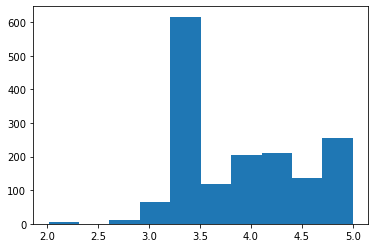

In [173]:
plt.hist(h2n['social_score'])

(array([  1.,   2.,   4.,  26., 586., 150., 236., 198., 131., 285.]),
 array([1.73333333, 2.06      , 2.38666667, 2.71333333, 3.04      ,
        3.36666667, 3.69333333, 4.02      , 4.34666667, 4.67333333,
        5.        ]),
 <a list of 10 Patch objects>)

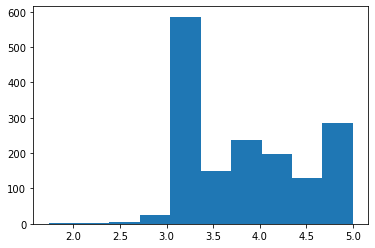

In [175]:
plt.hist(h2n['social_score'])

(array([  2.,   0.,   6.,  32., 590., 154., 209., 205., 124., 297.]),
 array([1.84242424, 2.15818182, 2.47393939, 2.78969697, 3.10545455,
        3.42121212, 3.7369697 , 4.05272727, 4.36848485, 4.68424242,
        5.        ]),
 <a list of 10 Patch objects>)

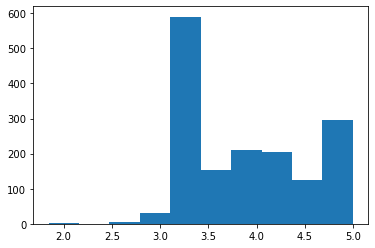

In [177]:
plt.hist(h2n['social_score'])

In [ ]:
""